<a href="https://colab.research.google.com/github/AnikaitLakhotia/Machine-Learning/blob/main/Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
from zipfile import ZipFile
import os
import pandas as pd
import tensorflow.keras as keras
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt

In [ ]:
# Get data
url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip = ZipFile(keras.utils.get_file(origin=url, fname="jena_climate_2009_2016.csv.zip"))
zip.extractall()

data_frame = pd.read_csv("jena_climate_2009_2016.csv")

In [ ]:
# Data normalization function
def normalize(data, train_split):
  mean = data[:train_split].mean(axis=0)
  stand_dev = data[:train_split].std(axis=0)
  return (data - mean) / stand_dev

In [ ]:
train_split = 5000

In [ ]:
# Lookup statistics
data_frame.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),420551.0,989.212776,8.358481,913.60,984.20,989.58,994.72,1015.35
T (degC),420551.0,9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28
Tpot (K),420551.0,283.492743,8.504471,250.60,277.43,283.47,289.53,311.34
Tdew (degC),420551.0,4.955854,6.730674,-25.01,0.24,5.22,10.07,23.11
rh (%),420551.0,76.008259,16.476175,12.95,65.21,79.30,89.40,100.00
VPmax (mbar),420551.0,13.576251,7.739020,0.95,7.78,11.82,17.60,63.77
VPact (mbar),420551.0,9.533756,4.184164,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),420551.0,4.042412,4.896851,0.00,0.87,2.19,5.30,46.01
sh (g/kg),420551.0,6.022408,2.656139,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),420551.0,9.640223,4.235395,0.80,6.29,8.96,12.49,28.82


In [ ]:
# Select only a few features
selected_features = pd.concat([data_frame['T (degC)'], data_frame['p (mbar)'], data_frame['rh (%)'], data_frame['VPact (mbar)'], data_frame['wv (m/s)'], data_frame['rho (g/m**3)']], axis=1)
selected_features.index = data_frame['Date Time']
selected_features = selected_features.iloc[::6, :]
selected_features

,T (degC),p (mbar),rh (%),VPact (mbar),wv (m/s),rho (g/m**3)
Date Time,,,,,,
01.01.2009 00:10:00,-8.02,996.52,93.30,3.11,1.03,1307.75
01.01.2009 01:10:00,-7.62,996.50,94.80,3.26,0.18,1305.68
01.01.2009 02:10:00,-8.85,996.63,93.50,2.92,0.16,1312.11
01.01.2009 03:10:00,-8.84,996.87,93.50,2.92,0.07,1312.37
01.01.2009 04:10:00,-9.23,997.05,92.20,2.79,0.10,1314.62
...,...,...,...,...,...,...
31.12.2016 19:20:00,-1.40,1002.08,70.20,3.87,1.08,1282.68
31.12.2016 20:20:00,-2.15,1001.42,68.77,3.59,0.79,1285.50
31.12.2016 21:20:00,-2.61,1001.05,71.80,3.62,0.77,1287.20


In [ ]:
features_normalized = normalize(selected_features.values, train_split)
features = pd.DataFrame(features_normalized)
features

,0,1,2,3,4,5
0,-1.872262,0.929121,1.050190,-1.414015,-0.711494,2.066426
1,-1.826070,0.926917,1.143860,-1.377636,-1.294939,2.017414
2,-1.968109,0.941241,1.062680,-1.460096,-1.308667,2.169660
3,-1.966954,0.967685,1.062680,-1.460096,-1.370444,2.175816
4,-2.011991,0.987519,0.981499,-1.491625,-1.349852,2.229090
...,...,...,...,...,...,...
70087,-1.107793,1.541747,-0.392325,-1.229693,-0.677174,1.472834
70088,-1.194402,1.469025,-0.481623,-1.297601,-0.876232,1.539604
70089,-1.247522,1.428257,-0.292410,-1.290325,-0.889960,1.579856
70090,-1.317964,1.368757,-0.317389,-1.333980,-0.835047,1.634314


In [ ]:
# Training and validation data
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

In [ ]:
# Data from the past 7 days will be tracked for each prediction, which is equivalent to the 168th timestamp ( 7 × 24 = 168 ).
# This data will be used to predict the temperature 24 hours into the future, which is equivalent to 24 timestamps

start = 168 + 24
end = start + train_split

x_train = train_data.values
y_train = features.iloc[start:end][[0]]


In [ ]:
training_dataset = keras.preprocessing.timeseries_dataset_from_array(
    data=x_train,
    targets=y_train,
    sequence_length=168,
    sampling_rate=6,
    batch_size=64,
)

In [ ]:
x_end = len(val_data) - start

label_start = train_split + start

x_val = val_data.iloc[:x_end][[i for i in range(6)]].values
y_val = features.iloc[label_start:][[0]]

validation_dataset = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=168,
    batch_size=64,
)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

model = Sequential()
model.add(layers.GRU(20, dropout=0.2, recurrent_dropout=0.5, return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.1), input_shape=(None, selected_features.shape[-1])))
model.add(layers.GRU(40, activation='relu', dropout=0.2, recurrent_dropout=0.5, kernel_regularizer=keras.regularizers.l2(0.1)))
model.add(layers.Dense(1))

In [ ]:
# Complilation
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

In [ ]:
# Train model
history = model.fit(
    training_dataset,
    epochs=10,
    validation_data=validation_dataset,
)

Epoch 1/10
63/63 [==============================] - 199s 3s/step - loss: 3.8972 - val_loss: 2.5245
Epoch 2/10
63/63 [==============================] - 192s 3s/step - loss: 1.9950 - val_loss: 1.5418
Epoch 3/10
63/63 [==============================] - 194s 3s/step - loss: 1.1870 - val_loss: 0.9412
Epoch 4/10
63/63 [==============================] - 189s 3s/step - loss: 0.8264 - val_loss: 0.7358
Epoch 5/10
63/63 [==============================] - 190s 3s/step - loss: 0.6456 - val_loss: 0.6139
Epoch 6/10
63/63 [==============================] - 189s 3s/step - loss: 0.5514 - val_loss: 0.5436
Epoch 7/10
63/63 [==============================] - 192s 3s/step - loss: 0.4956 - val_loss: 0.5171
Epoch 8/10
63/63 [==============================] - 189s 3s/step - loss: 0.4602 - val_loss: 0.4930
Epoch 9/10
63/63 [==============================] - 218s 3s/step - loss: 0.4292 - val_loss: 0.4807
Epoch 10/10
63/63 [==============================] - 220s 4s/step - loss: 0.3998 - val_loss: 0.4816


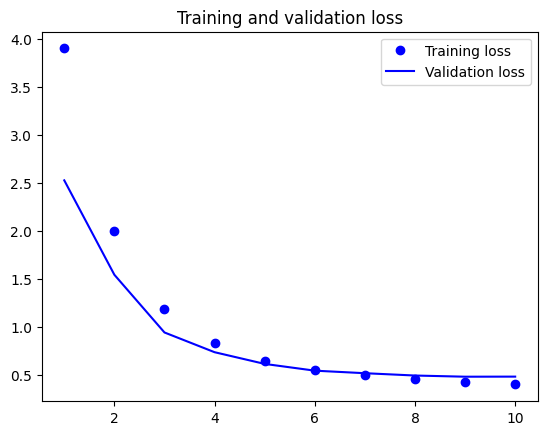

In [ ]:
# Plot training and validation losses
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()